# Baseline - Quantile Random Forest for Time Series Prediction

## Objective of this Notebook

1. Apply a machine learning algorithm in time series prediction

In [42]:
# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 15, 6

from datetime import datetime
import pandas as pd
import numpy as np

# ignore warnings in this demo notebook
import warnings; warnings.simplefilter('ignore')

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from skgarden import RandomForestQuantileRegressor

from python_code.data_preparation import load_series
from python_code.data_preparation import series_to_supervised

## Task Description

### Data Parameters

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. In this example, we just have a look at one series, namely with id `MAC000002`. We have:

- Number of series: 1
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)

In [14]:
data_path = 'prepared_data/london_smart_meter/'
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

### Experiment Parameters

In this experiment we will fit a quantile random forest and perform a one day ahead prediction. A rolling forecast will be performed with 28 days for training. As this experiment shall be compareable to the other experiments, we 2014-01-28 will be the first day of prediction.

In [15]:
h_params = {'n_in': 24 * 28, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train_start =  datetime.strptime('2013-12-31 00:00:00', '%Y-%m-%d %H:%M:%S')
df = df[df.index >= date_train_start]

## Simple Model

Let us start predicting one day ahead energy consumption just using hour and weekday as features. 

### Prepare Data for Quantile Regression

In [47]:
df_energy = df[['energy']]
df_energy['hour'] = df_energy.index.hour
df_energy['weekday'] = df_energy.index.weekday
df_energy.head()

,energy,hour,weekday
date,,,
2013-12-31 00:00:00+01:00,0.888,0,1
2013-12-31 01:00:00+01:00,0.894,1,1
2013-12-31 02:00:00+01:00,0.312,2,1
2013-12-31 03:00:00+01:00,0.219,3,1
2013-12-31 04:00:00+01:00,0.218,4,1


Lets do our first prediction.

In [35]:
X_train = df_energy[:h_params['n_in']][['hour', 'weekday']]
y_train = df_energy[:h_params['n_in']][['energy']]
X_train.shape

(672, 2)

In [36]:
rfqr = RandomForestQuantileRegressor(random_state=0)
rfqr.fit(X_train, y_train)

RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=None,
               max_features='auto', max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=0, verbose=0,
               warm_start=False)

In [37]:
yHat_train = rfqr.predict(X_train)

In [38]:
def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

In [39]:
smape(yHat_train, y_train.values)

35.41292339820931

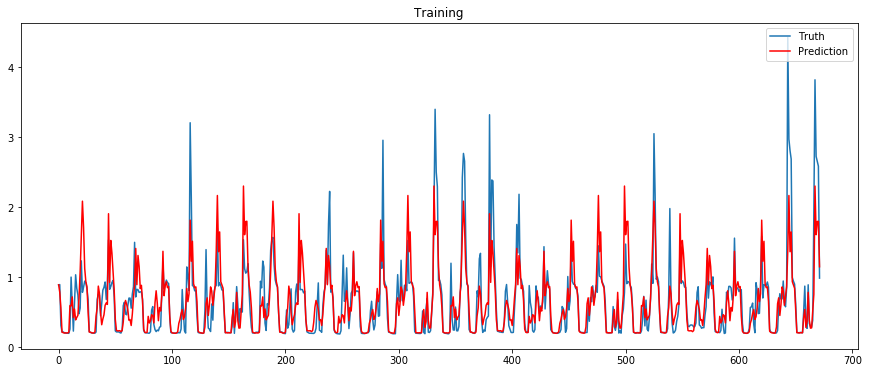

In [46]:
plt.plot(y_train['energy'].values)
plt.plot(yHat_train, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Training")
plt.show()

In [50]:
X_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['hour', 'weekday']]
y_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['energy']]
X_test.shape

(24, 2)

In [52]:
yHat_test = rfqr.predict(X_test)
smape(yHat_test, y_test.values)

34.9539533844047

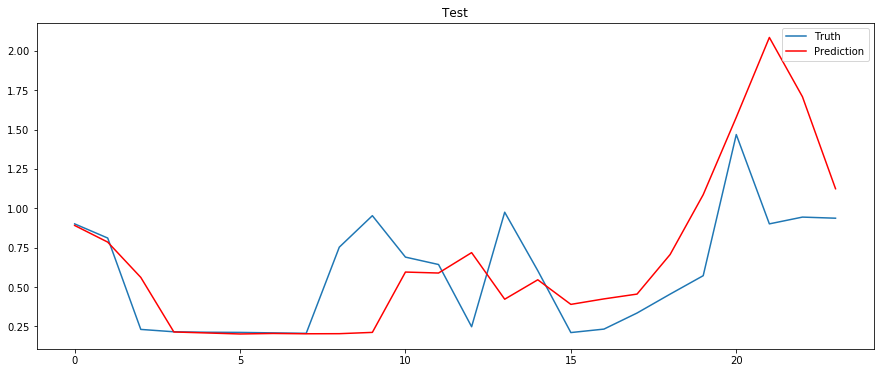

In [53]:
plt.plot(y_test['energy'].values)
plt.plot(yHat_test, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Test")
plt.show()

It would be hard to do a rolling forecast this way. Let us write some helper functions.

In [67]:
def prepare_train_test(df, y, features, n_in, n_out, current_step, step_foreward):
    step = current_step * step_foreward
    start_train = step
    end_train = n_in + step
    X_train = df[start_train:end_train][features]
    y_train = df[start_train:end_train][y]
    
    start_test = end_train
    end_test = start_test + n_out
    X_test = df[start_test:end_test][features]
    y_test = df[start_test:end_test][y]
    return X_train, y_train, X_test, y_test


def n_possible_steps(df, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    return int((timesteps - n_in - n_out) / step_foreward)


def rolling_forecast_experiment(df, y, features, n_in, n_out, step_foreward): 
    n_steps = n_possible_steps(df, n_in, n_out, step_foreward)
    
    smape_values = []
    for i in range(0, n_steps):
        rfqr = RandomForestQuantileRegressor(random_state=0)
        X_train, y_train, X_test, y_test = prepare_train_test(df, y, features, n_in, n_out, i, step_foreward)
        rfqr.fit(X_train, y_train)
        yHat = rfqr.predict(X_test)
        smape_values.append(smape(yHat, y_test.values))
    return smape_values
    

In [77]:
y = ['energy']
features = ['hour', 'weekday']
n_in = h_params['n_in']
n_out = h_params['n_out']

In [78]:
n_possible_steps(df_energy, n_in, n_out, n_out)

30

We have by experiment design 30 days to predict. In each of this 30 steps, we will use the 28 days before that day we want to predict as training data. 

When you change some of this parameters, you have to be cautious, as it will cut-off the end of the series when `(n - n_in - n_out) / step_size` is not an integer. You may apply before following function:

In [ ]:
def cut_data_at_start(data, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    steps = int((timesteps - n_in - n_out) / step_foreward)
    nDrop = timesteps - (steps * n_out + n_in + n_out)
    if nDrop > 0:
        df = df[nDrop:]
    return df

In [74]:
smape_values = rolling_forecast_experiment(df_energy, y, features, n_in, n_out, n_out)

In [76]:
np.median(smape_values)

35.48607707481044

We got an median SMPAE value of 35.49%. Let us try to add more features.

## More Features

In this section we add additional to the time related features some weather features. We **assume** in this experiment that the weather features in `X_test` are weather forecasts. This may be not practicable for longer prediction windows.

In [79]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,id,energy,hour,weekday
date,,,,,,,,,,,,
2013-12-31 00:00:00+01:00,11.46,170,6.82,4.94,1012.35,4.62,3.10,0.88,MAC000002,0.888,0,1
2013-12-31 01:00:00+01:00,11.41,162,6.92,5.43,1011.76,4.62,3.29,0.90,MAC000002,0.894,1,1
2013-12-31 02:00:00+01:00,11.57,161,7.50,6.02,1010.82,5.19,3.52,0.90,MAC000002,0.312,2,1
2013-12-31 03:00:00+01:00,11.96,161,8.11,6.31,1009.59,5.92,3.53,0.88,MAC000002,0.219,3,1
2013-12-31 04:00:00+01:00,12.26,161,8.72,7.08,1008.74,6.14,4.63,0.89,MAC000002,0.218,4,1


In [86]:
y = ['energy']
features = ['hour', 'weekday', 'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity']
n_in = h_params['n_in']
n_out = h_params['n_out']

In [87]:
smape_values = rolling_forecast_experiment(df, y, features, n_in, n_out, n_out)

In [88]:
np.median(smape_values)

35.01954147672926

Unfortunately, we do not have any improvement.